In [1]:
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

In [2]:
mmirs = WFSFactory(wfs="mmirs")

In [10]:
# Parameters describing MMIRS pickoff mirror geometry

# Location and diameter of exit pupil
zp = 71.749 / 0.02714  # Determined by tracing chief ray at 7.2' field angle with 
                       # mmirs_asbuiltoptics_20110107_corronly.zmx
dp = zp / 5.18661 # Working f/# from Zemax file

# central obscuration ratio from optics.h in shwfs
obsc = mmirs.telescope.obscuration

# Location of fold mirror
zm = 114.8

# Angle of fold mirror 
am = 42 * u.deg

# Following dimensions from drawing MMIRS-1233_Rev1.pdf
# Diameter of pickoff mirror
diam = (6.3 * u.imperial.inch).to(u.mm).value

# X size of opening in pickoff mirror
xsize = (3.29 * u.imperial.inch).to(u.mm).value

# Y size of opening in pickoff mirror
ysize = (3.53 * u.imperial.inch).to(u.mm).value

# radius of corner  in pickoff mirror
rcirc = (0.4 * u.imperial.inch).to(u.mm).value

In [11]:
# Compute intersection of ray with pickoff mirror
# The ray leaves the exit pupil at position x,y and hits the focal surface at x0,y0
# Math comes from http://geomalgorithms.com/a05-_intersect-1.html
def mirrorpoint(x0, y0, x, y):
    # Point in focal plane
    P0 = np.array([x0, y0, 0])

    # Point in exit pupil
    P1 = np.array([x * dp / 2, y * dp / 2, zp])

    # Pickoff mirror intesection with optical axis
    V0 = np.array([0, 0, zm])

    # normal to mirror
    if (x0 < 0):
        n = np.array([-np.sin(am), 0, np.cos(am)])
    else:
        n = np.array([np.sin(am), 0, np.cos(am)])
    
    w = P0 - V0

    # Vector connecting P0 to P1
    u = P1 - P0

    # Distance from P0 to intersection as a fraction of abs(u)
    s = -n.dot(w) / n.dot(u)

    # Intersection point on mirror
    P = P0 + s * u

    return (P[0], P[1])

In [12]:
# Determine if a point is on the mirror surface
# x,y = coordinates of ray 
# side=1 means right face of the pickoff mirror, -1=left face
def onmirror(x, y, side):
    if np.hypot(x, y) > diam / 2.:
        # print "Outside diameter", x,y
        return False
    if x * side < 0:
        # print "Wrong side of mirror", x, y
        return False
    x = abs(x)
    y = abs(y)
    if ((x>xsize/2) or (y>ysize/2)
        or (x > xsize/2-rcirc and y > ysize/2-rcirc and np.hypot(x-(xsize/2-rcirc), y-(ysize/2-rcirc)) > rcirc)):
        #print "Success!", x, y
        return True
    else:
        #print "Otherwise outside", x, y, xsize/2, ysize/2
        return False

In [13]:
# Draw mirror outline
def drawoutline(ax):
    circ = np.arange(360) * u.deg
    ax.plot(np.cos(circ) * diam/2, np.sin(circ) * diam/2, "b")
    ax.set_aspect('equal', 'datalim')
    ax.plot([-(xsize/2-rcirc), (xsize/2-rcirc)], [ysize/2, ysize/2], "b")
    ax.plot([-(xsize/2-rcirc), (xsize/2-rcirc)], [-ysize/2, -ysize/2], "b")
    ax.plot([-(xsize/2), -(xsize/2)], [ysize/2-rcirc, -(ysize/2-rcirc)], "b")
    ax.plot([(xsize/2), (xsize/2)], [ysize/2-rcirc, -(ysize/2-rcirc)], "b")
    ax.plot(np.cos(circ[0:90])*rcirc + xsize/2 - rcirc, np.sin(circ[0:90]) * rcirc + ysize/2 - rcirc, "b")
    ax.plot(np.cos(circ[90:180])*rcirc - xsize/2 + rcirc, np.sin(circ[90:180])*rcirc + ysize/2 - rcirc, "b")
    ax.plot(np.cos(circ[180:270])*rcirc - xsize/2 + rcirc, np.sin(circ[180:270])*rcirc - ysize/2 + rcirc, "b")
    ax.plot(np.cos(circ[270:360])*rcirc + xsize/2 - rcirc, np.sin(circ[270:360])*rcirc - ysize/2 + rcirc, "b")
    ax.plot([0,0],[ysize/2,diam/2],"b")
    ax.plot([0,0],[-ysize/2,-diam/2],"b")

In [38]:
# Plot a grid of points representing shack hartmann apertures corresponding to wavefront sensor at x0,y0 in mm
# This position is written in the FITS header keywords GUIDERX and GUIDERY
def plotgrid(x0, y0, ax, npts=14):
    for x in np.arange(-1, 1.00001, 2.0 / npts):
        for y in np.arange(-1, 1.00001, 2.0 / npts):
            if (np.hypot(x, y) <= 1 and np.hypot(x, y) >= obsc): # Only plot points within the telescope aperture
                xm, ym = mirrorpoint(x0, y0, x, y)  # Get intersection with pickoff
                if onmirror(xm, ym, x0/abs(x0)):  # Find out if point is on the mirror surface
                    ax.scatter(xm, ym, 1, "g")
                else:
                    ax.scatter(xm, ym, 1, "r")

<IPython.core.display.Javascript object>


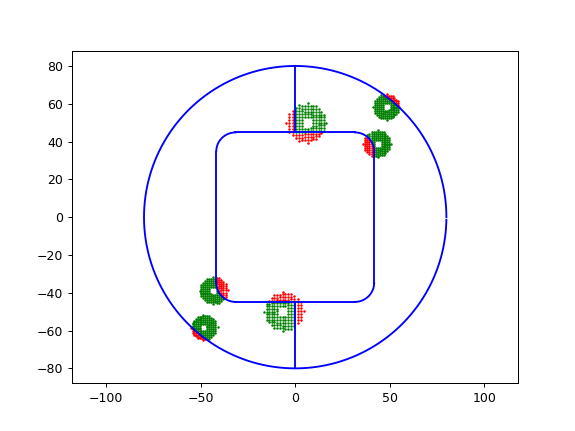

In [39]:
fig, ax = plt.subplots()
drawoutline(ax)

# Some representative positions that vignette on different edges of the mirror
plotgrid(-50, -60, ax)
plotgrid(-45, -40, ax)
plotgrid(-7, -52, ax)
plotgrid(50, 60, ax)
plotgrid(45, 40, ax)
plotgrid(7, 52, ax)
fig.show()

<IPython.core.display.Javascript object>


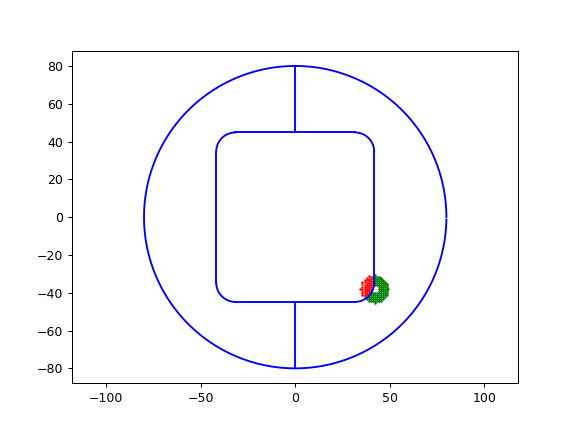

In [48]:
# The PacMan from last WFS image on 2017.1019
fig, ax = plt.subplots()
drawoutline(ax)
plotgrid(43.7, -39.14, ax)  # use GUIDERX/Y to place and then CA to rotate to match
fig.show()

<IPython.core.display.Javascript object>


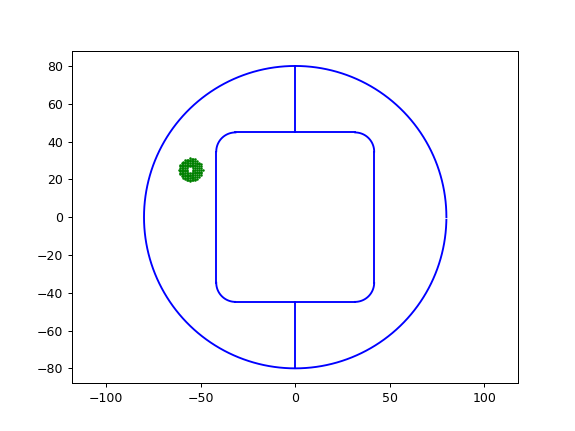

In [45]:
fig, ax = plt.subplots()
drawoutline(ax)
plotgrid(-57.08, 25.74, ax)
fig.show()